In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
if torch.cuda.is_available():
    print("CUDA is enabled.")
    torch.device("cuda")

In [2]:
rgb = []
colors = []
categories = []
for data in open("labels.csv", "r").read().splitlines()[1:]:
    r, g, b, label = data.split(",")
    rgb.append((float(r)/255, float(g)/255, float(b)/255))
    colors.append(label)

categories = sorted(list(set(colors)))
colors_enc = [categories.index(c) for c in colors]
print(categories)
print(f"Expected initial loss: {-torch.tensor(1/len(categories)).log()}")

['Black', 'Blue', 'Brown', 'Green', 'Grey', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow']
Expected initial loss: 2.397895336151123


In [40]:
# Initialization
inputs = torch.tensor(rgb).float()
labels = F.one_hot(torch.tensor(colors_enc)).float()
print(inputs.shape, labels.shape)

# split training and test sets
split_idx = int(len(rgb) * 0.9)
trainX, trainY = inputs[:split_idx], labels[:split_idx]
valX, valY = inputs[split_idx:], labels[split_idx:]
print(trainX.shape, valX.shape)

hidden_layer_dim = 50

W1 = torch.randn((3, hidden_layer_dim)) * 0.4 # * (5/3)/(3**0.5)
B1 = torch.randn((hidden_layer_dim)) * 0.1
W2 = torch.randn((hidden_layer_dim, labels.shape[1])) * 0.01
B2 = torch.randn((labels.shape[1])) * 0.0

# BatchNorm parameters
bngain = torch.ones((1, hidden_layer_dim))
bnbias = torch.zeros((1, hidden_layer_dim))
bnmean_running = torch.zeros((1, hidden_layer_dim))
bnstd_running = torch.ones((1, hidden_layer_dim))

parameters = [W1, B1, W2, B2]#, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

torch.Size([5052, 3]) torch.Size([5052, 11])
torch.Size([4546, 3]) torch.Size([506, 3])


In [41]:
epochs = 100000
batch_size = 32
loss_history = []
sat_history = []

for i in range(epochs):
    bix = torch.randint(0, trainX.shape[0], (batch_size,))
    batch_input, batch_labels = trainX[bix], trainY[bix]
    
    hpreact = batch_input @ W1 + B1
    
    # bnmeani = hpreact.mean(0, keepdim=True)
    # bnstdi = hpreact.std(0, keepdim=True)
    # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # with torch.no_grad():
    #     bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    #     bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    X = h.abs().view(-1)
    sat_history.append(len(X[X >= 0.99])/len(X))
    
    logits = h @ W2 + B2
    
    loss = F.cross_entropy(logits.softmax(dim=1), batch_labels)
    loss_history.append(loss.log10().item())

    if i % 10000 == 0:
        print(loss)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < epochs * 0.8 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    break

tensor(2.3979, grad_fn=<DivBackward1>)


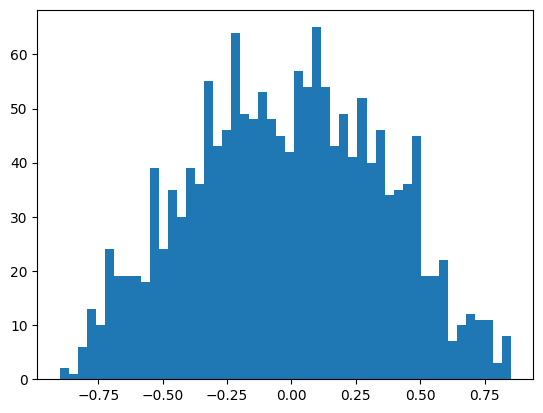

In [42]:
# plt.plot(range(len(sat_history)), sat_history);
plt.hist(h.view(-1).tolist(), 50);

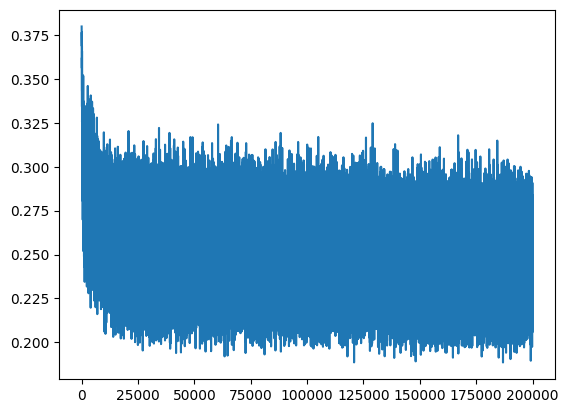

In [19]:
plt.plot(range(len(loss_history)), loss_history);

In [42]:
with torch.no_grad():
  hpreact = valX @ W1 + B1
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + B2
  probs = logits.softmax(dim=1)
  loss = F.cross_entropy(probs, valY)
  print(loss)
  # plt.hist(hpreact.view(-1).tolist(), 50);

tensor(1.8633)


In [58]:
with torch.no_grad():
  color = torch.tensor([38,37,36]).float() / 255
  hpreact = color @ W1 + B1
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2
  print(logits)
  probs = logits.softmax(dim=0)
  # print("\n".join([f"{categories[i]}: {p.item():.4f}" for i, p in enumerate(probs)]))
  print(categories[torch.argmax(probs)])
  # plt.pie([1], colors=[color]);
  # plt.pie(probs, labels=categories, colors=categories);

tensor([ -0.2587,   0.1293,   8.6381,   7.8257,   2.8562,  -0.5689, -17.9795,
          0.8862,  -0.7173,  -0.3827,  -0.4641])
Brown
